# Exploring Abstention Loss
author: Elizabeth A. Barnes, Randal J. Barnes
date: January 9, 2021, 1530MST

* based on Thulasidasan, S., T. Bhattacharya, J. Bilmes, G. Chennupati, and J. Mohd-Yusof, 2019: Combating Label Noise in Deep Learning Using Abstention. arXiv [stat.ML],.
* thesis: https://digital.lib.washington.edu/researchworks/handle/1773/45781
* code base is here: https://github.com/thulas/dac-label-noise/blob/master/dac_loss.py

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import random
import xarray as xr
import scipy.stats as stats
import random
import time
import sys
from collections import Counter
import os.path
from os import path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import palettable
import pprint

import metrics
import climatedata
import plots
import experiments

import imp
imp.reload(experiments)
imp.reload(plots)

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)


In [2]:
NP_SEED = 99
np.random.seed(NP_SEED)

In [3]:
def in_ipynb():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            mpl.use('Agg')            
            return False
    except:
        mpl.use('Agg')        
        return False
    return True

# Internal functions

In [4]:
def get_exp_name(loss, data_name, extra_text = ''):
    # set experiment name
    if loss == 'DNN':
        EXP_NAME = (
            data_name
            + '_DNN'
            + '_prNoise' + str(PR_NOISE)
            + '_networkSeed' + str(NETWORK_SEED)
            + '_npSeed' + str(NP_SEED)
        )                
    else:
        EXP_NAME = (
            data_name
            + '_' + loss
            + '_' + UPDATER
            + '_abstSetpoint' + str(setpoint)
            + '_prNoise' + str(PR_NOISE)
            + '_networkSeed' + str(NETWORK_SEED)
            + '_npSeed' + str(NP_SEED)
    )

    return EXP_NAME + extra_text



In [5]:
def find_nearest(array, value):
    array = np.asarray(array, dtype=float)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_frac_correct(y_true,y_pred):
    icorr = np.where(y_pred - y_true == 0)[0]
    if(len(y_true)==0):
        return 0., icorr
    else:
        return len(icorr)/len(y_true), icorr

def get_acc_stats(onehotlabels, y_pred, tranquil, abstain, dnn=False):
    
    cat_pred = np.argmax(y_pred,axis=-1)
    cat_true = np.argmax(onehotlabels,axis=-1)

    if(dnn is True):
        max_logits = np.max(y_pred,axis=-1)
        i_cover = np.where(max_logits >= np.percentile(max_logits, 100.*abstain))[0]
    else:
        i_cover = np.where(cat_pred != abstain)[0]        
    
    acc, j_corr = get_frac_correct(cat_true[i_cover],cat_pred[i_cover])
    n = len(i_cover)
    n_corr = len(j_corr)
    n_tr_corr = np.sum(tranquil[i_cover][j_corr])
    n_tr = np.sum(tranquil[i_cover])

    i_tr = np.where(tranquil[i_cover]==1)[0]
    acc_tr, __ = get_frac_correct(cat_true[i_cover][i_tr], cat_pred[i_cover][i_tr])

    i_tr = np.where(tranquil[i_cover]==0)[0]
    acc_ntr, __ = get_frac_correct(cat_true[i_cover][i_tr], cat_pred[i_cover][i_tr])

    return acc, acc_tr, acc_ntr, n, n_tr, n_tr_corr, n_corr


In [6]:
### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [7]:
def plot_stats_clean(df, savename, lines=False, shades=True, ymin=0.1, ymin_frac=.1):
    
    yticks = np.round(np.arange(0.1,1.1,.1),2)
    ABSTENTION_VAR = 'coverage'
    plt.figure(figsize=(6*1,4*3))
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", palettable.cartocolors.qualitative.Vivid_6.mpl_colors)    

    #-------------------
    s0 = plt.subplot(3,1,1)
    plots.plot_stats_panel(df, var='acc', abstention_var=ABSTENTION_VAR, legend=True, lines=lines, shades=shades)
#     plt.yscale('log')
    plt.yticks(yticks, labels=yticks)
    plt.ylim(ymin,1.01)    
    format_spines(s0)
    
    #-------------------
    s1 = plt.subplot(3,1,2)
    plots.plot_stats_panel(df, var='acc_tr', abstention_var=ABSTENTION_VAR, legend=True, lines=lines, shades=shades)
    plots.plot_stats_panel(df, var='acc_ntr', abstention_var=ABSTENTION_VAR, legend=True, lines=True, shades=True)    
    plt.title('(b) Tranquil Accuracy', fontsize=FS,color='k')  
#     plt.yscale('log')
    plt.yticks(yticks, labels=yticks)
    plt.ylim(ymin,1.01)
    format_spines(s1)    
    
    
    #-------------------
    s2 = plt.subplot(3,1,3)
    plots.plot_stats_panel(df, var='frac_tr', abstention_var=ABSTENTION_VAR, legend=False, lines=lines, shades=shades)
    plt.title('(c) Fraction Covered that are Tranquil', fontsize=FS,color='k')    
#     plt.yscale('log')
    plt.yticks(yticks, labels=yticks)    
    plt.ylim(ymin_frac,1.01)    
    format_spines(s2)  
    
    
    #----------------------------------------------------------
    s0.set_title(savename + '\n(a) Total Accuracy', fontsize=FS,color='k')        
    plt.tight_layout()
    
    return savename

In [8]:
def add_dataframe_info(df):
    data = df.copy()
    
    data.loc[data.data_name=='badClasses0','base_exp'] = 'badClasses'
    data.loc[data.data_name=='badClasses0','loss_type'] = 'NotWrongLoss'

    data.loc[data.data_name=='badClasses1','base_exp'] = 'badClasses'
    data.loc[data.data_name=='badClasses1','loss_type'] = 'DACLoss'

    data.loc[data.data_name=='mixedLabels2','base_exp'] = 'mixedLabels'
    data.loc[data.data_name=='mixedLabels2','loss_type'] = 'NotWrongLoss'

    data.loc[data.data_name=='mixedLabels3','base_exp'] = 'mixedLabels'
    data.loc[data.data_name=='mixedLabels3','loss_type'] = 'DACLoss'

    data.loc[data.data_name=='tranquilFOO10','base_exp'] = 'tranquilFOO_0.5'
    data.loc[data.data_name=='tranquilFOO10','loss_type'] = 'NotWrongLoss'

    data.loc[data.data_name=='tranquilFOO12','base_exp'] = 'tranquilFOO_0.5'
    data.loc[data.data_name=='tranquilFOO12','loss_type'] = 'DACLoss'

    data.loc[data.data_name=='tranquilFOO17','base_exp'] = 'tranquilFOO_1.0'
    data.loc[data.data_name=='tranquilFOO17','loss_type'] = 'NotWrongLoss'

    data.loc[data.data_name=='tranquilFOO18','base_exp'] = 'tranquilFOO_1.0'
    data.loc[data.data_name=='tranquilFOO18','loss_type'] = 'DACLoss'
    
    data.loc[data.data_name=='tranquilFOO20','base_exp'] = 'tranquilFOO_0.5x'
    data.loc[data.data_name=='tranquilFOO20','loss_type'] = 'NotWrongLoss' 
    
    data.loc[data.data_name=='tranquilFOO22','base_exp'] = 'tranquilFOO_0.5x'
    data.loc[data.data_name=='tranquilFOO22','loss_type'] = 'DACLoss'     
    
    return data

def change_dataframe_names(df):
    data = df.copy()
    
    data.loc[data.data_name=='badClasses0','data_name'] = 'badClasses'
    data.loc[data.data_name=='badClasses1','data_name'] = 'badClasses-dacLoss'

    data.loc[data.data_name=='mixedLabels2','data_name'] = 'mixedLabels'
    data.loc[data.data_name=='mixedLabels3','data_name'] = 'mixedLabels-dacLoss'

    data.loc[data.data_name=='tranquilFOO10','data_name'] = 'tranquilFOO_0.5'
    data.loc[data.data_name=='tranquilFOO12','data_name'] = 'tranquilFOO_0.5-dacLoss'

    data.loc[data.data_name=='tranquilFOO17','data_name'] = 'tranquilFOO_1.0'
    data.loc[data.data_name=='tranquilFOO18','data_name'] = 'tranquilFOO_1.0-dacLoss'
    
    data.loc[data.data_name=='tranquilFOO20','data_name'] = 'tranquilFOO_0.5x'
    data.loc[data.data_name=='tranquilFOO22','data_name'] = 'tranquilFOO_0.5x-dacLoss'    
    
    return data

# Load the dataframes

In [9]:
RELOAD = False

DATA_NAME_LIST = (  
                'badClasses0',
                'badClasses1',    
                'mixedLabels2',
                'mixedLabels3',    
                'tranquilFOO10',
                'tranquilFOO12',    
                'tranquilFOO17',  
                'tranquilFOO18',  
                'tranquilFOO20',      
                'tranquilFOO22',          
                  )
abstain_setpoint = np.around(np.arange(0., 1.05, .05), 3)
seed_vector = np.arange(0,50)
var = 'acc'
df_all = pd.DataFrame(columns=('epochs',
                               'network_seed',
                               'np_seed',
                               'app_type',
                               'setpoint',
                               'frac_abstain',
                               'coverage',
                               'acc',
                               'acc_tr',
                               'acc_ntr',
                               'n_cover',
                               'n_tr',
                               'n_tr_corr',
                               'n_corr',
                               'frac_tr',                               
                               'frac_corr_tr',
                               'acc_portion_tr',
                               'acc_portion_ntr',
                               'perf_frac_tr',
                               'data_name',
                              )) 
df_max = pd.DataFrame(columns=('coverage',
                                  'setpoint',
                                  'dnn_value',
                                  'dac_value',
                                  'diff',     
                                  'diff_type',                               
                                  'data_name',
                                 ))
df_all_med = pd.DataFrame(columns=('coverage',
                                  'setpoint',
                                  'dnn_value',
                                  'dac_value',
                                  'diff',     
                                  'diff_type',                               
                                  'data_name',
                                 ))
df_all_max = pd.DataFrame(columns=('coverage',
                                  'setpoint',
                                  'dnn_value',
                                  'dac_value',
                                  'diff',     
                                  'diff_type',
                                  'data_name',
                                 )) 
if RELOAD:
    for DATA_NAME in DATA_NAME_LIST:

        #----------------------
        # get the saved dataframe for this experiment
        print(DATA_NAME)
        EXPINFO = experiments.define_experiments(DATA_NAME)    
        savename = (DATA_NAME
                   + '_' + EXPINFO['loss']
                   + '_npSeed'
                   + str(EXPINFO['np_seed'])
                   )    
        df = pd.read_pickle('predictions/' + savename + '.pkl')
        df['data_name'] = DATA_NAME
        df_all = df_all.append(df,ignore_index = True)

        #----------------------    
        # grab maximum statistics
        # start by looping through setpoints
        for setpoint in abstain_setpoint:
            print('    setpoint = ' + str(setpoint))

            df_dac = df[(df['app_type']=='DAC') & (df['setpoint']==setpoint)]
            df_dnn = df[df['app_type']=='DNN']
            df_stats = df_dnn.groupby(['coverage']).describe()

            # loop through the CAN rows for one particular setpoint
            # to find the run with the maximum difference from the DNN
            # start by creating a dataframe of all possible differences
            # from the DNN maximum curve and save to df_all_max dataframe
            diff = []
            for index, row in df_dac.iterrows():
                x_dac = row['coverage']
                y_dac = row[var]
                j = find_nearest(df_stats.index.values, x_dac)
                x_dnn = df_stats.index.values[j]
                y_dnn = df_stats[(var,'max')].values[j]
                df1 = pd.DataFrame({'coverage':np.around(x_dac,3),
                                   'setpoint':setpoint,
                                   'dnn_value':y_dnn,
                                   'dac_value':y_dac,
                                   'diff': y_dac-y_dnn,
                                   'diff_type': 'all_max',
                                   'data_name': DATA_NAME,
                                  },index=[0])
                df_all_max = df_all_max.append(df1,ignore_index = True) 

                y_dnn = df_stats[(var,'50%')].values[j]
                df1 = pd.DataFrame({'coverage':np.around(x_dac,3),
                                   'setpoint':setpoint,
                                   'dnn_value':y_dnn,
                                   'dac_value':y_dac,
                                   'diff': y_dac-y_dnn,
                                   'diff_type': 'all_med',
                                   'data_name': DATA_NAME,
                                  },index=[0])
                df_all_med = df_all_med.append(df1,ignore_index = True) 


            # find the maximum difference between the CAN and the
            # DNN maximum curve and save to df_max dataframe
            diff = df_all_max[(df_all_max['setpoint']==setpoint) & (df_all_max['data_name']==DATA_NAME)]['diff']        
            if(diff.size==0):
                max_row = pd.DataFrame({'coverage':np.nan,
                                   'setpoint':np.nan,
                                   'dnn_value':np.nan,
                                   'dac_value':np.nan,
                                   'diff':np.nan,
                                   'data_name': np.nan,
                                  },index=[0])
            else:
                imax = diff.idxmax(axis=0)
                max_row = df_all_max[df_all_max['setpoint']==setpoint].loc[imax]

            df1 = pd.DataFrame({'coverage':max_row['coverage'],
                              'setpoint':max_row['setpoint'],
                              'dnn_value':max_row['dnn_value'],
                              'dac_value':max_row['dac_value'],
                              'diff': max_row['diff'],
                              'diff_type': 'max',                            
                              'data_name': DATA_NAME,                        
                               },index=[0]) 
            df_max = df_max.append(df1,ignore_index = True)


        #----------------------
        #save big 6-panel summary plot 
        plots.plot_stats_comparisons(df, savename=DATA_NAME, lines=True, shades=True)                
        plt.savefig('figures/paper_plots/' 
                    + '/statsComparisons_' 
                    + savename
                    +'.png',dpi=dpiFig)   
        plt.close()
        
    df_all = add_dataframe_info(df_all)
    df_max = add_dataframe_info(df_max)
    df_all_max = add_dataframe_info(df_all_max)
    df_all_med = add_dataframe_info(df_all_med)    

    df_all.to_pickle('predictions/' + 'df_all_finalExperiments' + '.pkl')
    df_max.to_pickle('predictions/' + 'df_max_finalExperiments' + '.pkl')
    df_all_max.to_pickle('predictions/' + 'df_all_max_finalExperiments' + '.pkl')    
    df_all_med.to_pickle('predictions/' + 'df_all_med_finalExperiments' + '.pkl')        
    print('done creating and saving.')   
    
else:
    df_all = pd.read_pickle('predictions/' + 'df_all_finalExperiments' + '.pkl')
    df_max = pd.read_pickle('predictions/' + 'df_max_finalExperiments' + '.pkl')
    df_all_max = pd.read_pickle('predictions/' + 'df_all_max_finalExperiments' + '.pkl')    
    df_all_med = pd.read_pickle('predictions/' + 'df_all_med_finalExperiments' + '.pkl')        
    print('done loading.')

# rename DAC - "CAN"    
# rename DNN - "ANN"    
# change the name of the experiments for the paper
df_all.loc[(df_all.app_type == 'DAC'),'app_type']='CAN' 
df_all.loc[(df_all.app_type == 'DNN'),'app_type']='ANN' 
df_all = change_dataframe_names(df_all)
df_max = change_dataframe_names(df_max)
df_all_max = change_dataframe_names(df_all_max)
df_all_med = change_dataframe_names(df_all_med)   

done loading.


In [10]:
DATA_NAME_LIST = (  
                'badClasses',
                'badClasses-dacLoss',    
                'mixedLabels',
                'mixedLabels-dacLoss',    
                'tranquilFOO_0.5',
                'tranquilFOO_0.5-dacLoss',    
                'tranquilFOO_1.0',  
                'tranquilFOO_1.0-dacLoss',          
                'tranquilFOO_0.5x',
                'tranquilFOO_0.5x-dacLoss',    
                  )

In [11]:
DATA_NAME_LIST

('badClasses',
 'badClasses-dacLoss',
 'mixedLabels',
 'mixedLabels-dacLoss',
 'tranquilFOO_0.5',
 'tranquilFOO_0.5-dacLoss',
 'tranquilFOO_1.0',
 'tranquilFOO_1.0-dacLoss',
 'tranquilFOO_0.5x',
 'tranquilFOO_0.5x-dacLoss')

In [12]:
raise ValueError()

ValueError: 

### 3-panel summaries

In [13]:
FS = 16

no such ax1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


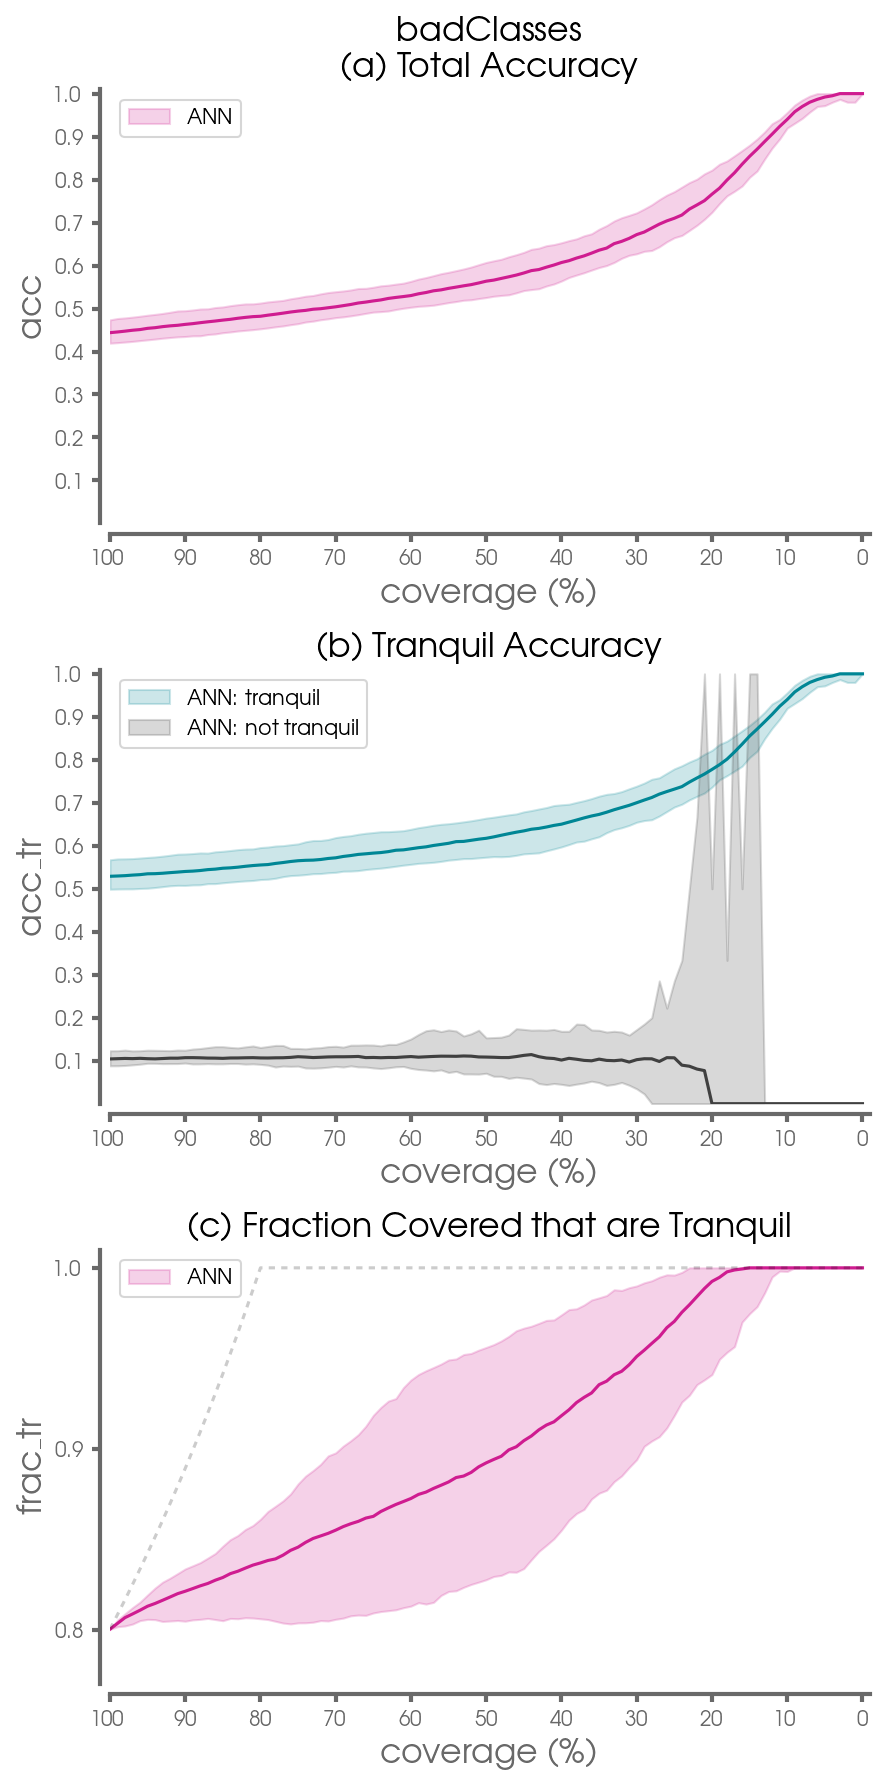

In [14]:
imp.reload(plots)

for DATA_NAME in ('badClasses',):

    #----------------------
    # save clean 3-panel plot    
    df_plot = df_all[df_all['data_name']==DATA_NAME]
    df_plot = df_plot[df_plot['app_type'] != 'DAC-DNN']
    df_plot = df_plot[df_plot['app_type'] != 'DNN-DNN']
    df_plot = df_plot[df_plot['app_type'] != 'SELENE']
    df_plot = df_plot[df_plot['app_type'] != 'ORACLE']
    df_plot = df_plot[df_plot['app_type'] != 'CAN']    

    if(DATA_NAME.find('badClasses')==0):
        ymin = 0.
        ymin_frac = .77
    elif(DATA_NAME.find('mixedLabels')==0):    
        ymin = .0
        ymin_frac = ymin
    elif(DATA_NAME.find('tranquilFOO_0.5')==0):    
        ymin = .0   
        ymin_frac = ymin
    elif(DATA_NAME.find('tranquilFOO_0.5')==0):        
        ymin = .0
        ymin_frac = .25
    plot_stats_clean(df_plot, savename=DATA_NAME, lines=True, shades=True, ymin=ymin, ymin_frac=ymin_frac)
    plt.savefig('figures/paper_plots/' 
                + '/cleanStats_DNNonly_' 
                + DATA_NAME
                +'.png',dpi=dpiFig)  
#     plt.show()
    plt.close()

In [ ]:
imp.reload(plots)

for DATA_NAME in DATA_NAME_LIST[-2:]:

    #----------------------
    # save clean 3-panel plot    
    df_plot = df_all[df_all['data_name']==DATA_NAME]
    df_plot = df_plot[df_plot['app_type'] != 'DAC-DNN']
    df_plot = df_plot[df_plot['app_type'] != 'DNN-DNN']
    df_plot = df_plot[df_plot['app_type'] != 'SELENE']
    df_plot = df_plot[df_plot['app_type'] != 'ORACLE']

    if(DATA_NAME.find('badClasses')==0):
        ymin = 0.
        ymin_frac = .77
    elif(DATA_NAME.find('mixedLabels')==0):    
        ymin = .0
        ymin_frac = ymin
    elif(DATA_NAME.find('tranquilFOO_0.5')==0):    
        ymin = .0   
        ymin_frac = ymin
    elif(DATA_NAME.find('tranquilFOO_1.0')==0):        
        ymin = .0
        ymin_frac = .25
    plot_stats_clean(df_plot, savename=DATA_NAME.replace('_','\_'), lines=True, shades=True, ymin=ymin, ymin_frac=ymin_frac)
    plt.savefig('figures/paper_plots/' 
                + '/cleanStats_' 
                + DATA_NAME
                +'.png',dpi=dpiFig)  
#     plt.show()
    plt.close()

### All three experiment accuracies

In [ ]:
imp.reload(plots)

yticks = np.round(np.arange(0.1,1.1,.1),2)

#----------------------
df_plot = df_all.copy()
df_plot = df_plot[df_plot['app_type'] != 'DAC-DNN']
df_plot = df_plot[df_plot['app_type'] != 'DNN-DNN']
df_plot = df_plot[df_plot['app_type'] != 'SELENE']
# df_plot = df_plot[df_plot['app_type'] != 'ORACLE']

ABSTENTION_VAR = 'coverage'
plt.figure(figsize=(6,12))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", palettable.cartocolors.qualitative.Vivid_6.mpl_colors)    

#-------------------
data_name = 'mixedLabels'
ax2=plt.subplot(3,1,2)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc', abstention_var=ABSTENTION_VAR, legend=True, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.4,1.01)  
plt.title('(b) ' + data_name.replace('_','\_'), fontsize=FS)
df_plot = df_plot[df_plot['app_type'] != 'ORACLE'] #turn off ORACLE for the rest of the plots
format_spines(ax2)
plt.ylabel('accuracy')


#-------------------
data_name = 'badClasses'
ax1=plt.subplot(3,1,1)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.4,1.01)  
plt.title('(a) ' + data_name.replace('_','\_'), fontsize=FS)
format_spines(ax1)
plt.ylabel('accuracy')

#-------------------
data_name = 'tranquilFOO_0.5x'
ax3=plt.subplot(3,1,3)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.25,1.01)    
plt.title('(c) ' + 'fooENSO', fontsize=FS)
plt.ylabel('accuracy')
format_spines(ax3)



plt.tight_layout()
plt.savefig('figures/paper_plots/' 
            + '/accuracy_allExperiments' 
            +'.png',dpi=dpiFig)  
plt.show()
# plt.close()

### Comparing large data set and small

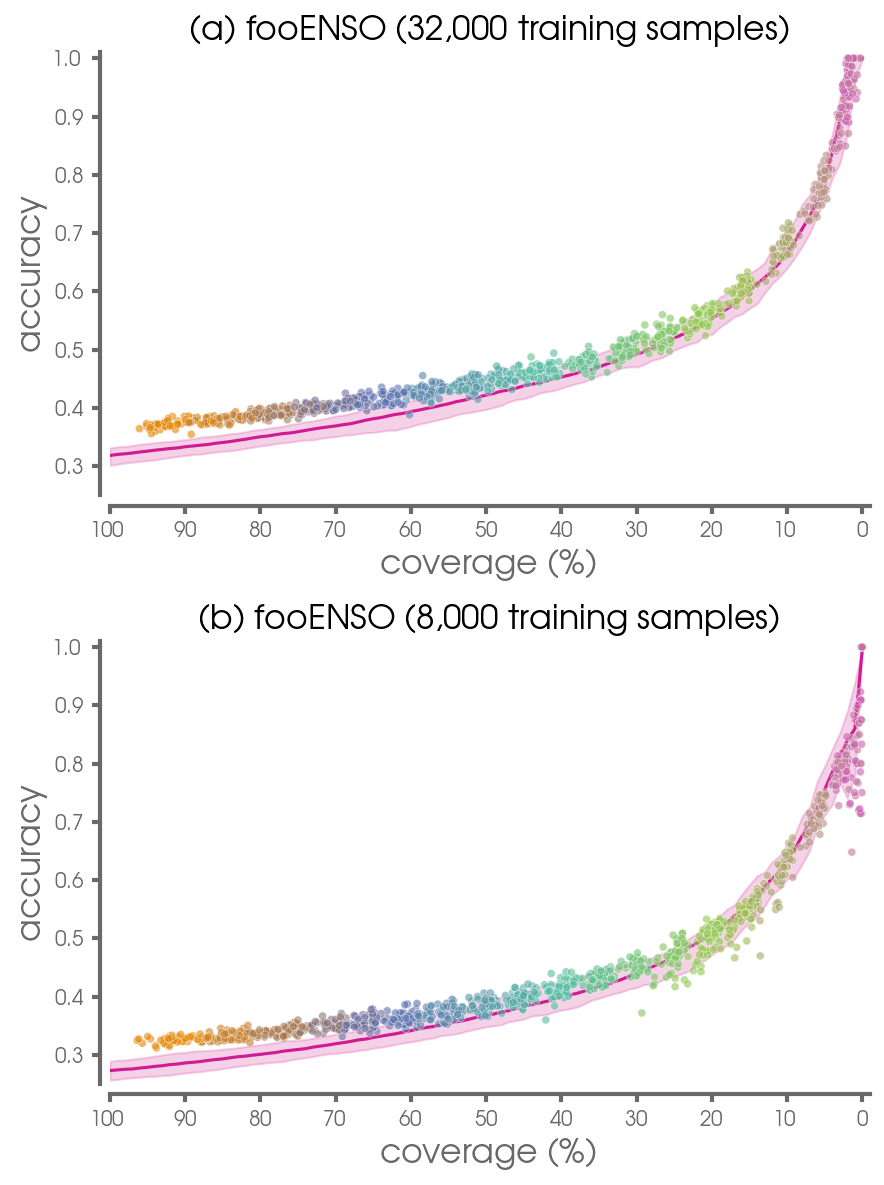

In [22]:
imp.reload(plots)

yticks = np.round(np.arange(0.1,1.1,.1),2)

#----------------------
df_plot = df_all.copy()
df_plot = df_plot[df_plot['app_type'] != 'DAC-DNN']
df_plot = df_plot[df_plot['app_type'] != 'DNN-DNN']
df_plot = df_plot[df_plot['app_type'] != 'SELENE']
df_plot = df_plot[df_plot['app_type'] != 'ORACLE']

ABSTENTION_VAR = 'coverage'
plt.figure(figsize=(6,8))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", palettable.cartocolors.qualitative.Vivid_6.mpl_colors)    

#-------------------
data_name = 'tranquilFOO_0.5x'
ax1=plt.subplot(2,1,1)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.25,1.01)    
plt.title('(a) ' + 'fooENSO (32,000 training samples)', fontsize=FS)
plt.ylabel('accuracy')
format_spines(ax1)

#-------------------
data_name = 'tranquilFOO_0.5'
ax3=plt.subplot(2,1,2)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.25,1.01)    
plt.title('(b) ' + 'fooENSO (8,000 training samples)', fontsize=FS)
plt.ylabel('accuracy')
format_spines(ax3)



plt.tight_layout()
plt.savefig('figures/paper_plots/' 
            + '/reviewer_compare_datasizes' 
            +'.png',dpi=dpiFig)  
plt.show()
# plt.close()

### Decision-making process of tranquil and badClasses

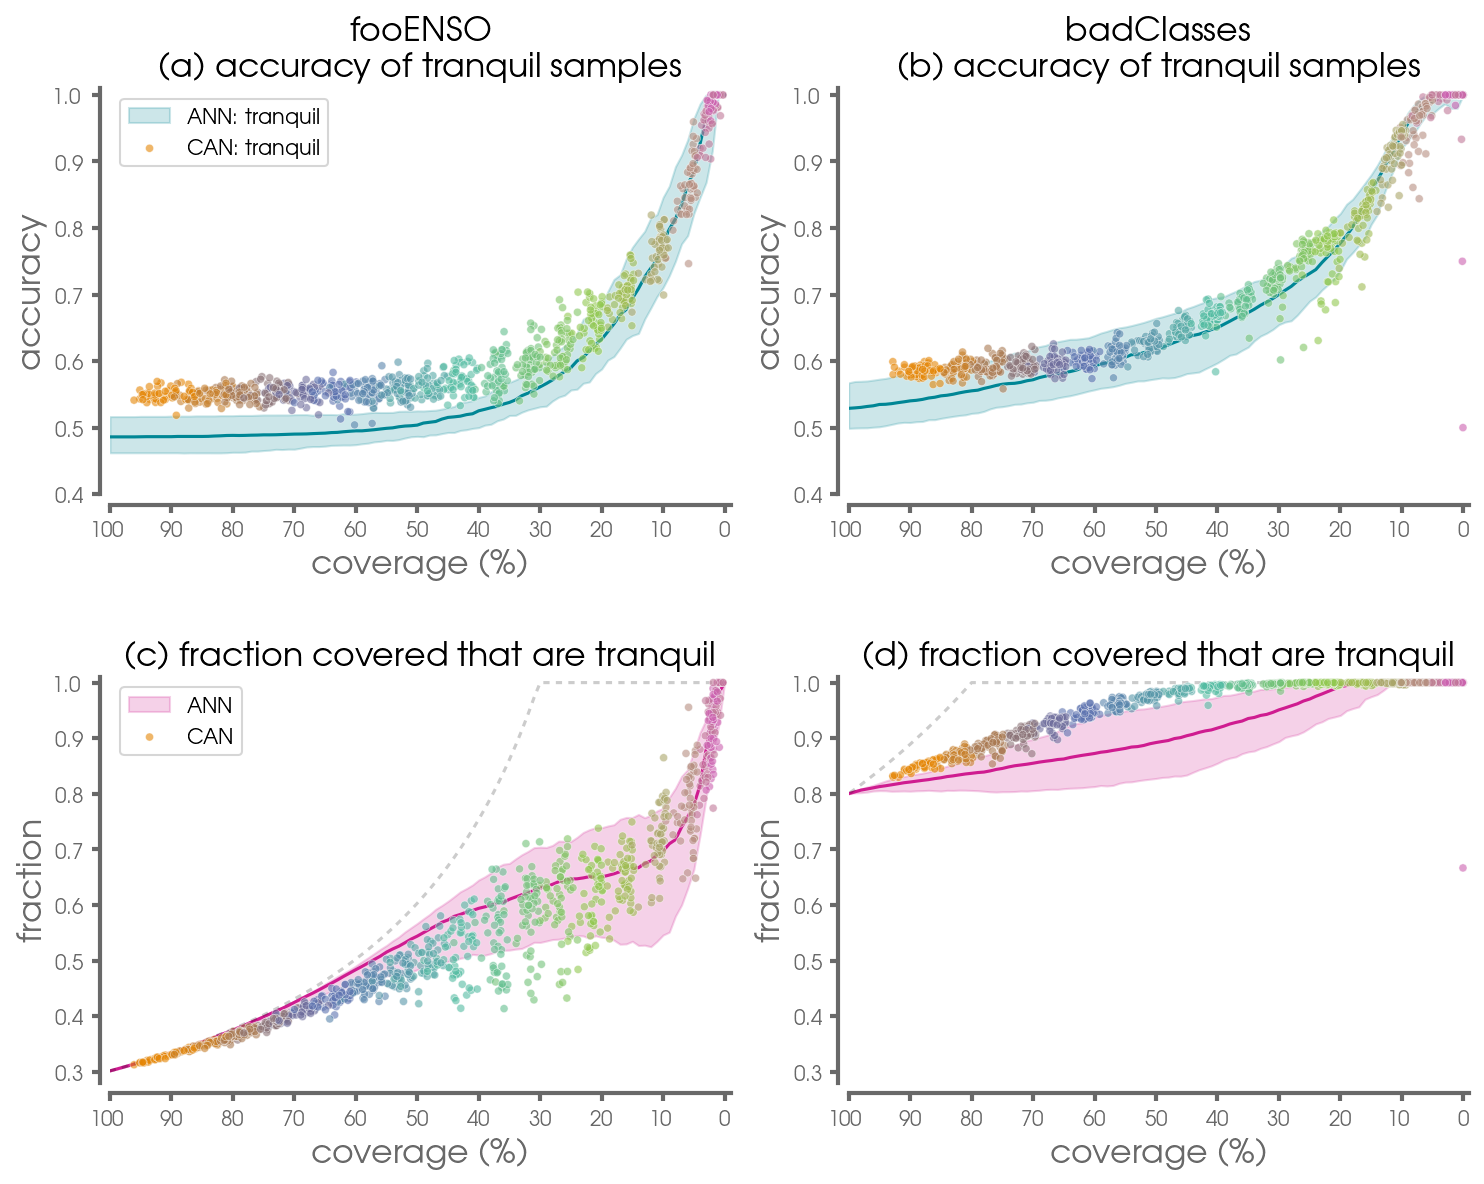

In [21]:
imp.reload(plots)

yticks = np.round(np.arange(0.1,1.1,.1),2)

#----------------------
df_plot = df_all.copy()
df_plot = df_plot[df_plot['app_type'] != 'DAC-DNN']
df_plot = df_plot[df_plot['app_type'] != 'DNN-DNN']
df_plot = df_plot[df_plot['app_type'] != 'SELENE']
df_plot = df_plot[df_plot['app_type'] != 'ORACLE']

ABSTENTION_VAR = 'coverage'
plt.figure(figsize=(10,8))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", palettable.cartocolors.qualitative.Vivid_6.mpl_colors)    

#-------------------
data_name = 'badClasses'
ax1=plt.subplot(2,2,2)
format_spines(ax1)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc_tr', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
# plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc_ntr', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.4,1.01)  
plt.title(data_name.replace('_','\_') + '\n(b) accuracy of tranquil samples',fontsize=FS)
plt.ylabel('accuracy')

#-------------------
data_name = 'tranquilFOO_0.5x'
ax2=plt.subplot(2,2,1)
format_spines(ax2)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc_tr', abstention_var=ABSTENTION_VAR, legend=True, lines=True, shades=True)
# plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='acc_ntr', abstention_var=ABSTENTION_VAR, legend=True, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.4,1.01)  
plt.title('fooENSO' + '\n(a) accuracy of tranquil samples',fontsize=FS)
plt.ylabel('accuracy')

#-------------------
data_name = 'badClasses'
ax3=plt.subplot(2,2,4)
format_spines(ax3)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='frac_tr', abstention_var=ABSTENTION_VAR, legend=False, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.28,1.01)    
plt.title('\n(d) fraction covered that are tranquil',fontsize=FS)
plt.ylabel('fraction')

#-------------------
data_name = 'tranquilFOO_0.5x'
ax4=plt.subplot(2,2,3)
format_spines(ax4)
plots.plot_stats_panel(df_plot[df_plot['data_name']==data_name], var='frac_tr', abstention_var=ABSTENTION_VAR, legend=True, lines=True, shades=True)
plt.yticks(yticks, labels=yticks)
plt.ylim(.28,1.01)    
plt.title('\n(c) fraction covered that are tranquil',fontsize=FS)
plt.ylabel('fraction')



plt.tight_layout()
plt.savefig('figures/paper_plots/' 
            + '/tranquil_accuracy_allExperiments' 
            +'.png',dpi=dpiFig)  
plt.show()
# plt.close()

### Swarmplot of the differences

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


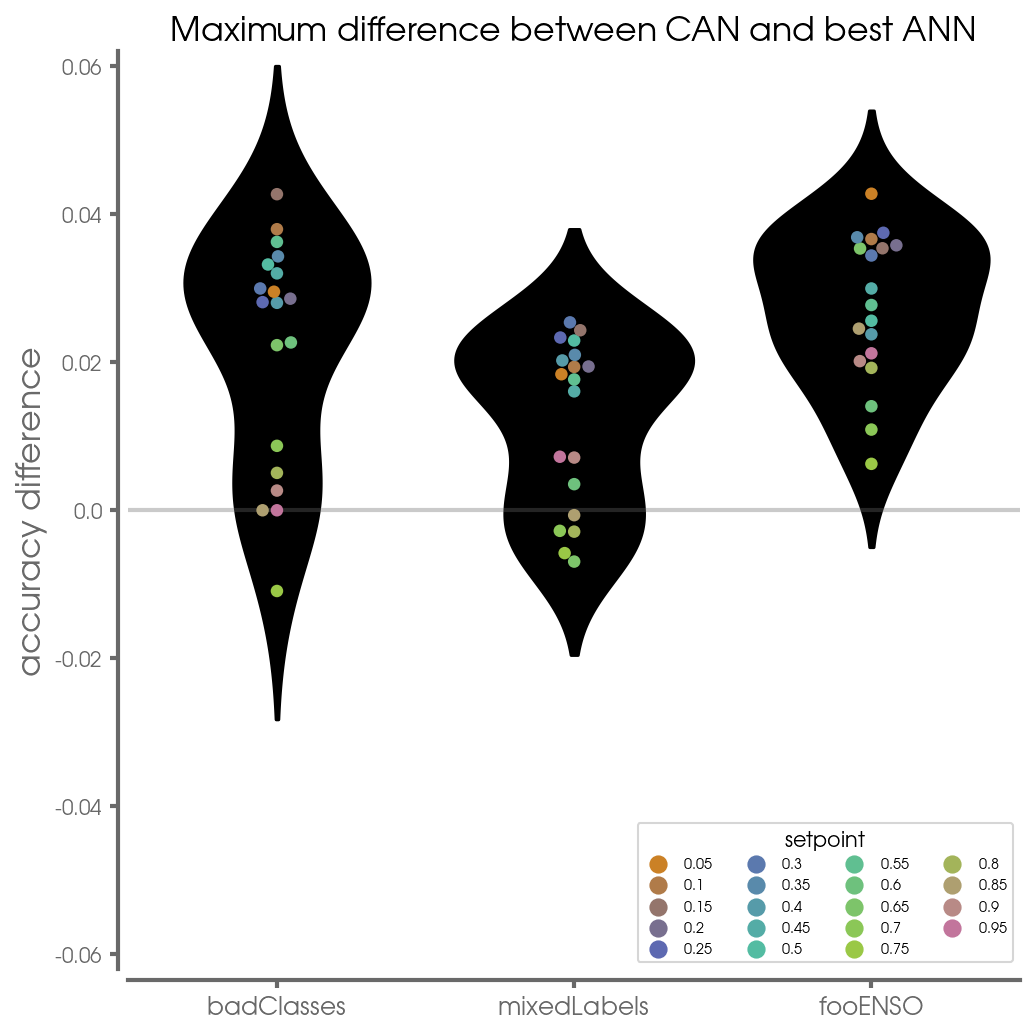

In [24]:
#-----------------
# VIOLIN PLOT
#-----------------
FS = 16
abstention_var = 'setpoint'
var = 'diff'
cmap = palettable.cartocolors.qualitative.Vivid_5.mpl_colormap
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=19)

for kind in ('max',):
    if(kind=='max'):
        data = df_max.copy()        
        size = 6
        yval = 6.2/100.
        title = 'Maximum difference between CAN and best ANN'
        inner = None
    elif(kind=='all_med'):
        data = df_all_med.copy()        
        size = 1.0
        yval = 13./100.
        title = 'Difference between CAN and median-ANN'
        inner = 'box'
        
#     data[var] = data[var].multiply(100)
    data = data[data['data_name'] != 'badClasses-dacLoss']
    data = data[data['data_name'] != 'mixedLabels-dacLoss']
    data = data[data['data_name'] != 'tranquilFOO_0.5-dacLoss']    
    data = data[data['data_name'] != 'tranquilFOO_1.0-dacLoss']
    data = data[data['data_name'] != 'tranquilFOO_0.5x-dacLoss']    
    data = data[data['data_name'] != 'tranquilFOO_1.0']
    data = data[data['data_name'] != 'tranquilFOO_0.5']    
    
    #-----------------------------
    plt.figure(figsize=(7,7))
    s0=plt.subplot(1,1,1)
    format_spines(s0)
    sns.violinplot(data=data,
                  x="data_name", 
                  y=var, 
                  color = 'black',
                  inner=inner,
                  scale='area',#'area',
                  gridsize=200,
                  )
    ax1 = sns.swarmplot(data=data,
                  x='data_name', 
                  y=var, 
                  hue=abstention_var,
                  palette = cpal,
                  s=size,
                 )

    plt.title(title,fontsize=FS)
    plt.axhline(y=0,linewidth=2.,color='dimgrey',linestyle='-',alpha=0.35)
    # ax1.get_legend().remove()   
    plt.legend(loc=4,fontsize=7,title='setpoint',mode=None,ncol=4)
    plt.xlabel(None)
    plt.ylim(-yval,yval)        
    plt.ylabel('accuracy difference',fontsize=FS)
    xlabels = plt.gca().get_xticklabels()
    xlabels = ('badClasses','mixedLabels','fooENSO')
#     xlabels = [xlabels[i].get_text().replace('_','\_') for i in np.arange(0,len(xlabels))]
    plt.xticks(np.arange(0,len(xlabels)),xlabels,fontsize=FS*.75)
    yticks = np.around(plt.gca().get_yticks(),3)
    plt.yticks(yticks,map(str,yticks))
    plt.ylim(-yval,yval)    

    # #-----------------------------
    plt.tight_layout()
    plt.savefig('figures/paper_plots/' 
                + '/violinDifferences_finalExperiments_'
                + kind
                +'.png',dpi=dpiFig)  
    plt.show()
#     plt.close()


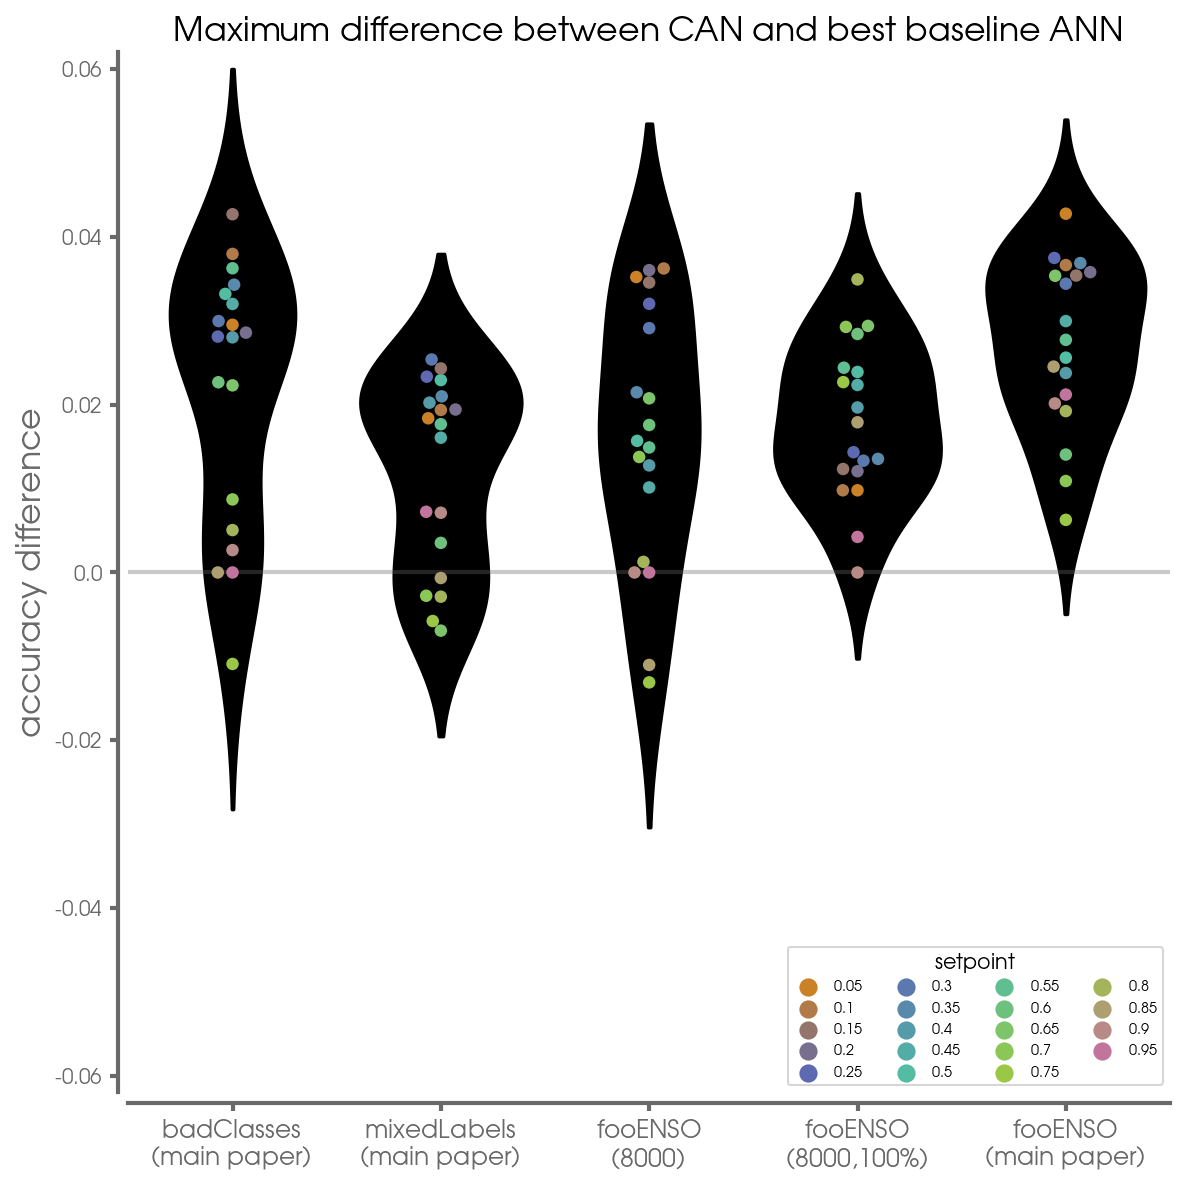

In [32]:
#-----------------
# VIOLIN PLOT
#-----------------

abstention_var = 'setpoint'
var = 'diff'
cmap = palettable.cartocolors.qualitative.Vivid_5.mpl_colormap
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=19)

for kind in ('max',):
    if(kind=='max'):
        data = df_max.copy()        
        size = 6
        yval = 6.2/100.
        title = 'Maximum difference between CAN and best baseline ANN'
        inner = None
    elif(kind=='all_med'):
        data = df_all_med.copy()        
        size = 1.0
        yval = 13./100.
        title = 'Difference between CAN and median-ANN'
        inner = 'box'
        
#     data[var] = data[var].multiply(100)
    data = data[data['data_name'] != 'badClasses-dacLoss']
    data = data[data['data_name'] != 'mixedLabels-dacLoss']
    data = data[data['data_name'] != 'tranquilFOO_0.5-dacLoss']    
    data = data[data['data_name'] != 'tranquilFOO_1.0-dacLoss']
    data = data[data['data_name'] != 'tranquilFOO_0.5x-dacLoss']    
    
    #-----------------------------
    plt.figure(figsize=(8,8))
    s0=plt.subplot(1,1,1)
    format_spines(s0)
    sns.violinplot(data=data,
                  x="data_name", 
                  y=var, 
                  color = 'black',
                  inner=inner,
                  scale='area',#'area',
                  gridsize=200,
                  )
    ax1 = sns.swarmplot(data=data,
                  x='data_name', 
                  y=var, 
                  hue=abstention_var,
                  palette = cpal,
                  s=size,
                 )

    plt.title(title,fontsize=FS)
    plt.axhline(y=0,linewidth=2.,color='dimgrey',linestyle='-',alpha=0.35)
    # ax1.get_legend().remove()   
    plt.legend(loc=4,fontsize=7,title='setpoint',mode=None,ncol=4)
    plt.xlabel(None)
    plt.ylim(-yval,yval)        
    plt.ylabel('accuracy difference',fontsize=FS)
#     xlabels = plt.gca().get_xticklabels()
#     xlabels = [xlabels[i].get_text().replace('_','\_') for i in np.arange(0,len(xlabels))]
    xlabels = ('badClasses\n(main paper)','mixedLabels\n(main paper)','fooENSO\n(8000)','fooENSO\n(8000,100\%)','fooENSO\n(main paper)')
    plt.xticks(np.arange(0,len(xlabels)),xlabels,fontsize=FS*.75)
    yticks = np.around(plt.gca().get_yticks(),3)
    plt.yticks(yticks,map(str,yticks))
    plt.ylim(-yval,yval)    

    # #-----------------------------
    plt.tight_layout()
    plt.savefig('figures/paper_plots/' 
                + '/violinDifferences_allExperiments_'
                + kind
                +'.png',dpi=dpiFig)  
    plt.show()
#     plt.close()


### Compare DACLoss and NotWrongLoss

In [33]:
#-----------------
# VIOLIN PLOT
#-----------------

abstention_var = 'setpoint'
var = 'diff'
cmap = palettable.cartocolors.qualitative.Vivid_5.mpl_colormap
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=19)

for kind in ('max',):
    if(kind=='max'):
        data = df_max.copy()        
        size = 6
        yval = 7.8/100
        title = 'Maximum difference between CAN and best baseline ANN'
        inner = 'stick'
    elif(kind=='all_med'):
        data = df_all_med.copy()        
        size = 1.0
        yval = 13./100
        title = 'Difference between CAN and median ANN'
        inner = None

#     data[var] = data[var].multiply(100) 

    #-----------------------------
    fig=plt.figure(figsize=(8,8))
    s0=plt.subplot(1,1,1)
    format_spines(s0)
    sns.violinplot(data=data,
                  x='base_exp', 
                  y=var,
                  hue='loss_type',
                  split=True, 
                  palette="muted", 
                  inner=inner,
                  scale='area',
                  )

    plt.ylim(-yval,yval)    
    plt.title(title.replace('_','\_'),fontsize=FS)
    plt.axhline(y=0 ,linewidth=2.,color='dimgrey',linestyle='-',alpha=.35)
    # ax1.get_legend().remove()   
    plt.legend(loc=2,fontsize=10,mode=None,ncol=2)
    plt.xlabel(None)
    plt.ylabel('accuracy difference',fontsize=FS)
#     xlabels = plt.gca().get_xticklabels()
#     xlabels = [xlabels[i].get_text().replace('_','\_') for i in np.arange(0,len(xlabels))]
    xlabels = ('badClasses\n(main paper)','mixedLabels\n(main paper)','fooENSO\n(8000)','fooENSO\n(8000,100\%)','fooENSO\n(main paper)')
    plt.xticks(np.arange(0,len(xlabels)),xlabels,fontsize=FS*.75)
    yticks = np.around(s0.get_yticks(),3)
    plt.yticks(yticks,map(str,yticks))
    plt.ylim(-yval,yval)    
    

    # #-----------------------------
    plt.tight_layout()
    plt.savefig('figures/paper_plots/' 
                + '/violinDifferences_compareLosses_'
                + kind
                +'.png',dpi=dpiFig)  
#     plt.show()
    plt.close()


### Plot abstention fraction with epoch

In [ ]:
import pickle
from matplotlib import gridspec

data_name = 'badClasses0'
history_dict = {}

best_dict = {.1:55, .2:62, .4:76, .7:70, .8:44} #badClasses0

for setpoint in (.1, .2, .4, .7, .8):
        
    exp_name = ('history_'
                    + str(data_name) 
                    + '_NotWrongLoss_Colorado_abstSetpoint' 
                    + str(setpoint) 
                    + '_prNoise1.0_networkSeed19_npSeed99'
               )
    history_file = ('saved_models/' 
                    + exp_name
                    + '.pickle'
                   )
    # Load data (deserialize)
    with open(history_file, 'rb') as handle:
        history_dict = pickle.load(handle)
#     pprint.pprint(history_dict, width=60)
    #----------------------------------------------------------
    
    MS = 7
    colors = cmap = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    clr_test = colors[1]
    clr_val = colors[-1]
    xticks = np.arange(0,120,10)

    fig=plt.figure(figsize=(7,8))
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[1, 2, 2])

    #-------------------------------
    last_epoch = best_dict[setpoint]-1
    epoch_len = len(history_dict['loss'])

    ax0 = fig.add_subplot(spec[0])
    format_spines(ax0)
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(history_dict['alpha_value'][:epoch_len],'.',label='alpha', markersize=MS,color='k')
    plt.title('Setpoint = ' + str(setpoint) + '',fontsize=FS)
    plt.legend(loc=0,mode=None,ncol=2)
    plt.xticks(xticks,labels='')
    plt.text(last_epoch-.3, 5.5, 'best epoch', color=colors[2], fontsize=9, horizontalalignment='right')
    plt.xlim(0,np.max(xticks))
    plt.ylim(0,6.5)
    yticks = ax0.get_yticks()
    plt.yticks(yticks,map(str,yticks))   
    

    ax1 = fig.add_subplot(spec[1])
    format_spines(ax1)    
    plt.axhline(y=setpoint,linewidth=1.,color='dimgrey',linestyle='-')
    plt.fill_between(x=np.arange(0,130),y1=setpoint-.1, y2=setpoint+.1, alpha = .1, color='dimgrey')
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(history_dict['abstention_fraction'][:epoch_len],'.',label='training', markersize=MS,color=clr_test)
    plt.plot(history_dict['val_abstention_fraction'][:epoch_len],'.', label='validation', markersize=MS,color=clr_val)
    plt.legend(mode=None,ncol=1,title='Abstention Fraction')
    plt.text(.35, setpoint, 'setpoint', color=(.5,.5,.5,1.), fontsize=9, horizontalalignment='left', verticalalignment='bottom')
    # plt.xlabel('epoch')
    plt.xticks(xticks,labels='')
    plt.ylim(0,1.)
    plt.xlim(0,np.max(xticks))
    yticks = np.around(ax1.get_yticks(),3)
    plt.yticks(yticks,map(str,yticks))   
    


    ax2 = fig.add_subplot(spec[2])
    format_spines(ax2)
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(np.asarray(history_dict['prediction_accuracy'][:epoch_len])*100,'.',label='training', markersize=MS,color=clr_test)
    plt.plot(np.asarray(history_dict['val_prediction_accuracy'][:epoch_len])*100,'.', label='validation', markersize=MS,color=clr_val)
    plt.legend(loc=4,mode=None,ncol=1,title='Accuracy (\%)')
    plt.xlabel('epoch',fontsize=FS)
    plt.xticks(xticks,labels=xticks)
    plt.ylim(0,100.)
    plt.xlim(0,np.max(xticks))
    yticks = np.asarray(ax2.get_yticks(),dtype='int')
    plt.yticks(yticks,map(str,yticks))   
    

    # #-----------------------------
    plt.tight_layout()
    plt.savefig('figures/paper_plots/' 
                + exp_name
                +'.png',dpi=dpiFig)  
    plt.close()
    

### Compare losses for dLoss/da_{k+1}

/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value enco

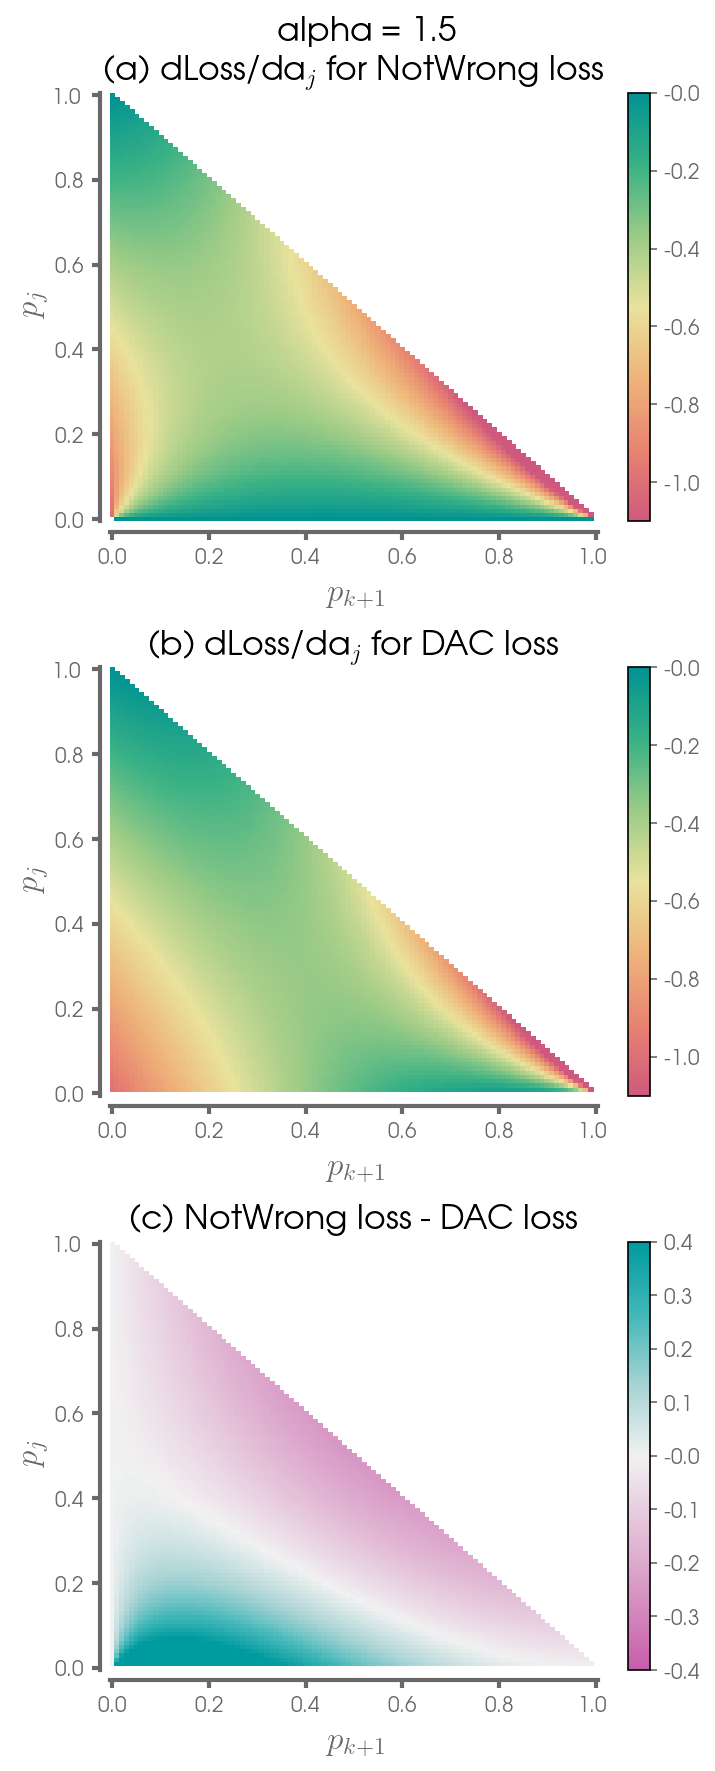

In [34]:
alpha = 1.5

pj_vec = np.arange(0.,1.01,.01)
pk1_vec = np.arange(0.,1.01,.01)

dl_nwl = np.zeros((len(pj_vec),len(pk1_vec)))*np.nan
dl_dl = np.zeros((len(pj_vec),len(pk1_vec)))*np.nan

for j,p_j in enumerate(pj_vec):
    for k,p_k1 in enumerate(pk1_vec):
        
        if(p_j+p_k1>1.):
            continue

        term1 = (alpha*p_k1)/(1-p_k1)
        term2 = (1-p_j-p_k1)/(p_j+p_k1)
        dl_nwl[j,k] = (-p_j * (term1 + term2))

        terma = -(1-p_j-p_k1)
        termb = p_k1*p_j*((1-p_k1)/p_j)
        termc = -alpha*((p_k1*p_j)/(1-p_k1))
        dl_dl[j,k] = (terma + termb + termc)
#         dl_dl[j,k] = -(1-p_j)*-1        

plt.figure(figsize=(15/3,4*3))
cmap = palettable.cartocolors.diverging.Temps_7_r.mpl_colormap
ticks = np.around(np.arange(0,1.2,.2),3)

ax1=plt.subplot(3,1,1)
format_spines(ax1)
plt.pcolor(pk1_vec,pj_vec,dl_nwl, cmap=cmap,shading='auto')
plt.clim(-1.1,0)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(np.around(np.arange(-1.,.2,.2),3)) 
plt.title('(a) dLoss/da$_{j}$ for NotWrong loss', fontsize=FS)
plt.xlabel('$p_{k+1}$',fontsize=FS)
plt.ylabel('$p_{j}$',fontsize=FS)
plt.xticks(ticks,map(str,ticks))
plt.yticks(ticks,map(str,ticks))


ax2=plt.subplot(3,1,2)
format_spines(ax2)
plt.pcolor(pk1_vec,pj_vec,dl_dl, cmap=cmap,shading='auto')
plt.clim(-1.1,0)
cbar=plt.colorbar()
cbar.ax.set_yticklabels(np.around(np.arange(-1.,.2,.2),3))
plt.title('(b) dLoss/da$_{j}$ for DAC loss', fontsize=FS)
plt.xlabel('$p_{k+1}$',fontsize=FS)
plt.ylabel('$p_{j}$',fontsize=FS)

plt.xticks(ticks,map(str,ticks))
plt.yticks(ticks,map(str,ticks))

ax3=plt.subplot(3,1,3)
format_spines(ax3)
cmap = palettable.cartocolors.diverging.Tropic_7_r.mpl_colormap
plt.pcolor(pk1_vec,pj_vec,dl_nwl-dl_dl, cmap=cmap,shading='auto')
plt.clim(-.4,.4)
cbar=plt.colorbar()
cbar.ax.set_yticklabels(np.around(np.arange(-.4,.5,.1),3))
plt.title('(c) NotWrong loss - DAC loss', fontsize=FS)
plt.xlabel('$p_{k+1}$',fontsize=FS)
plt.ylabel('$p_{j}$',fontsize=FS)
plt.xticks(ticks,map(str,ticks))
plt.yticks(ticks,map(str,ticks))

# #-----------------------------
plt.suptitle('alpha = ' + str(alpha), fontsize=FS)
plt.tight_layout()
plt.savefig('figures/paper_plots/' 
            + '/loss_comparisons'
            +'.png',dpi=dpiFig) 

plt.show()
# plt.close()